# Pricing Algorithm for Daniel Ershov's Study

This is a notebook where I conduct exploratory data analysis on the training data provided by Daniel Ershov for his study.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/output_data.csv')
data['price_diff'] = data['output_own_price'] - data['output_comp_price']
data['total_sales'] = data['output_own_sales'] / data['output_own_share']

for i in data['mkt_id'].unique():
    data.loc[data['mkt_id'] == i, 'index_day_of_year'] = range(1, len(data.loc[data['mkt_id'] == i])+1)

month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5,
              'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10,
              'nov': 11, 'dec': 12}
data['index_month'] = data['output_date'].apply(lambda x: x[2:5]).map(month_map)
data['bool_week_day'] = data['index_day_of_year'].apply(lambda x: 1 if (((x + 1) % 7 < 6) and ((x + 1) % 7 != 0)) else 0)

num_cols = data.select_dtypes(include='number')

In [3]:
data

,mkt_id,output_date,output_own_price,output_own_cost,output_comp_price,output_own_profits,output_X,output_own_share,output_own_sales,price_diff,total_sales,index_day_of_year,index_month,bool_week_day
0,44,01jan2019,7.05,5.90,7.11,15.065000,42.80,0.515267,13.10,-0.06,25.423698,1.0,1,1
1,44,02jan2019,7.05,6.05,7.11,24.310000,36.14,0.557082,24.31,-0.06,43.638108,2.0,1,1
2,44,03jan2019,7.05,5.98,7.28,30.783910,34.34,0.579922,28.77,-0.23,49.610146,3.0,1,1
3,44,04jan2019,7.05,5.98,7.28,20.169500,36.32,0.542767,18.85,-0.23,34.729426,4.0,1,1
4,44,05jan2019,6.79,6.07,6.68,1.231200,44.06,0.494757,1.71,0.11,3.456245,5.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19705,15555,27dec2019,7.28,5.96,7.30,26.070000,36.68,0.515118,19.75,-0.02,38.340759,361.0,12,1
19706,15555,28dec2019,6.69,5.94,6.64,3.720000,34.34,0.497312,4.96,0.05,9.973620,362.0,12,0
19707,15555,29dec2019,6.69,5.91,6.64,3.393001,32.00,0.424593,4.35,0.05,10.245098,363.0,12,0
19708,15555,30dec2019,7.31,5.99,7.42,31.561200,31.10,0.465712,23.91,-0.11,51.340710,364.0,12,1


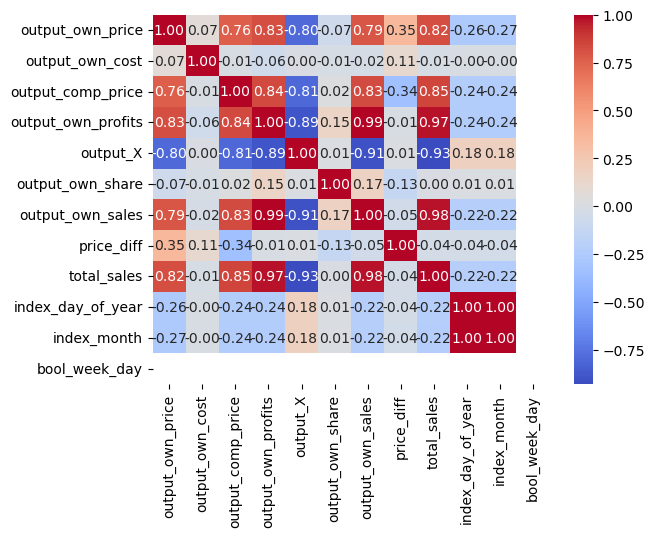

In [4]:
# Calculate correlation matrix
corr_matrix = num_cols.loc[num_cols['bool_week_day']==1].corr().drop('mkt_id', axis=1).drop('mkt_id', axis=0)

# Create heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Show plot
plt.show()

## Modelling total sales

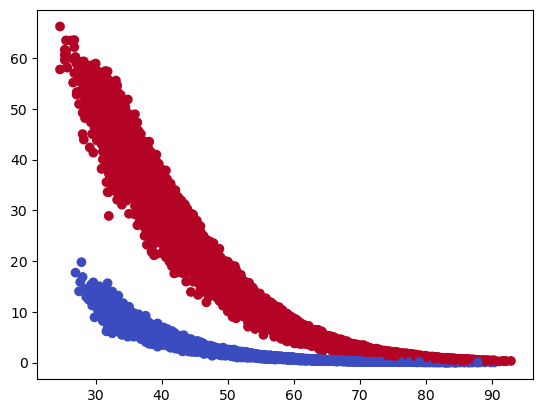

In [5]:
data_for_plot = data
plt.scatter(data_for_plot['output_X'], data_for_plot['total_sales'], c=data_for_plot['bool_week_day'], cmap='coolwarm')

Text(0, 0.5, 'Market Conditions')

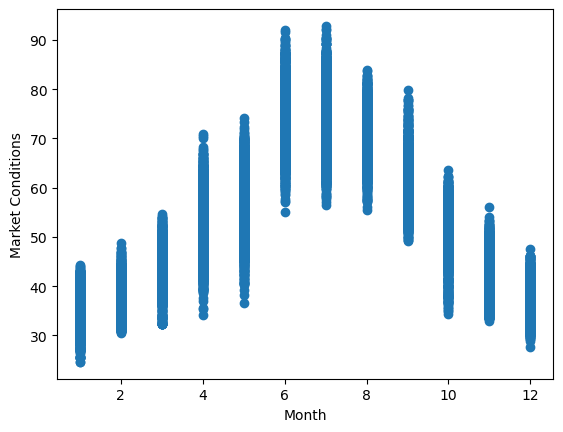

In [6]:
plt.scatter(data['index_month'], data['output_X'])
plt.xlabel('Month')
plt.ylabel('Market Conditions')

# Model 1: maximising share of total profit

!! Doesn't take into account that changing the price changes the total sales, assumes total sales is out of control.

In [120]:
# Sigmoid mu Normal MLE
def log_likelihood(params):
    mu = 1/ (1 + np.exp(-( params[0] + params[1] * data['bool_week_day'] + params[2] * data['price_diff'] + params[3] * data['price_diff'] * data['bool_week_day'])))
    sigma = params[4]
    n = len(data)
    ll = n/2 * np.log(sigma**2 * 2 * np.pi) + 1/ (2 * sigma**2) * sum((data['output_own_share'] - mu)**2)
    return ll

import scipy.optimize as opt

params_init = np.array([1, 1, 1, 1, 1])
results_mle = opt.minimize(log_likelihood, params_init)

results_mle.x

array([ 2.55108355e-04, -2.90864928e-03, -1.27492271e+00,  7.55555683e-01,
        7.65929547e-02])

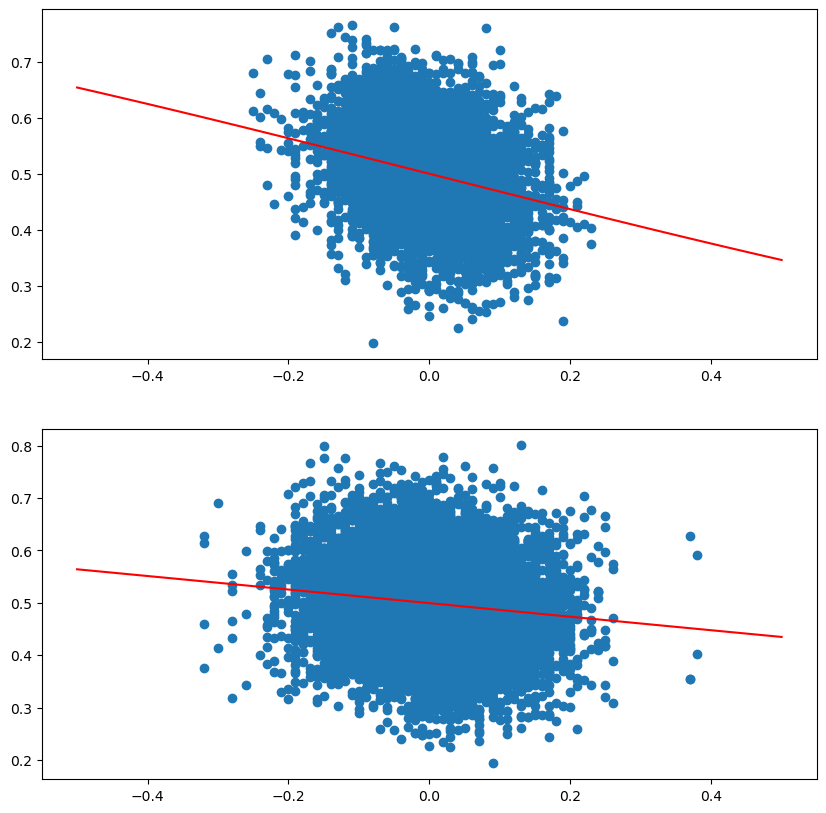

In [103]:
data_weekend = data.loc[data['bool_week_day'] == 0]
data_weekday = data.loc[data['bool_week_day'] == 1]
line = np.linspace(-0.5, 0.5, 100)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].scatter(data_weekend['price_diff'], data_weekend['output_own_share'])
ax[0].plot(line, 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[2] * line))), 'r')

ax[1].scatter(data_weekday['price_diff'], data_weekday['output_own_share'])
ax[1].plot(line, 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[1] + (results_mle.x[2] + results_mle.x[3]) * line))), 'r')

In [110]:
try_cost = 6

def model_one_price(cost, weekday=1):
    if weekday:
        return -1/(results_mle.x[2] + results_mle.x[3]) + cost
    return -1/results_mle.x[2] + cost

model_one_price(try_cost, weekday=0)

6.784361270760066

# Exploring the two splits (weekdays and weekends)

Intercept:  13.089977843128963
Coefficients:  [ 1.71378128e+01 -8.43447972e-01  1.79714555e-02 -1.97300062e-04
  1.10303766e-06 -2.50154153e-09 -5.78773741e+00 -3.30399835e+00]
R^2:  0.9789242149855613


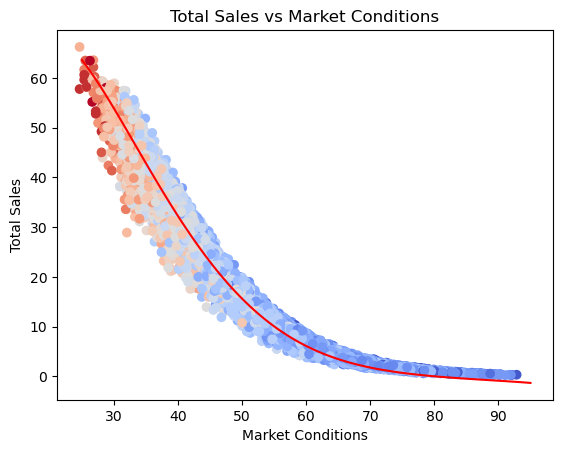

In [173]:
# Linear regression y=TS
# Note: make output_x**3 part of X
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Regression on weekdays
data_to_reg = data.loc[data['bool_week_day'] == 1]

degree = 6
poly = PolynomialFeatures(degree)
output_X_poly = np.array(poly.fit_transform(data_to_reg['output_X'].values.reshape(-1, 1)))

X = np.concatenate((output_X_poly[:, 1:], data_to_reg['output_own_price'].values.reshape(-1, 1), data_to_reg['output_comp_price'].values.reshape(-1, 1)), axis=1)
y = data_to_reg['total_sales']

reg_weekdays = LinearRegression().fit(X, y)

print('Intercept: ', reg_weekdays.intercept_)
print('Coefficients: ', reg_weekdays.coef_)
print('R^2: ', reg_weekdays.score(X, y))

# Plot
data_to_plot = data.loc[data['bool_week_day'] == 1]
plt.scatter(data_to_plot['output_X'], data_to_plot['total_sales'], c=data_to_plot['output_own_price'], cmap='coolwarm')

plt.xlabel('Market Conditions')
plt.ylabel('Total Sales')
plt.title('Total Sales vs Market Conditions')

line = np.linspace(25, 95, 100)
plt.plot(line, reg_weekdays.intercept_ + np.sum([reg_weekdays.coef_[i]*line**(i+1) for i in range(degree)],axis=0) + reg_weekdays.coef_[degree]*data_to_plot['output_own_price'].mean() + reg_weekdays.coef_[degree+1]*data_to_plot['output_comp_price'].mean(), 'r')

Intercept:  135.53538121976743
Coefficients:  [-6.58240394e+00  1.64426461e-01 -2.11337132e-03  1.39180888e-05
 -3.74241864e-08 -2.03189386e+00 -1.92451870e+00]
R^2:  0.9628250389094414


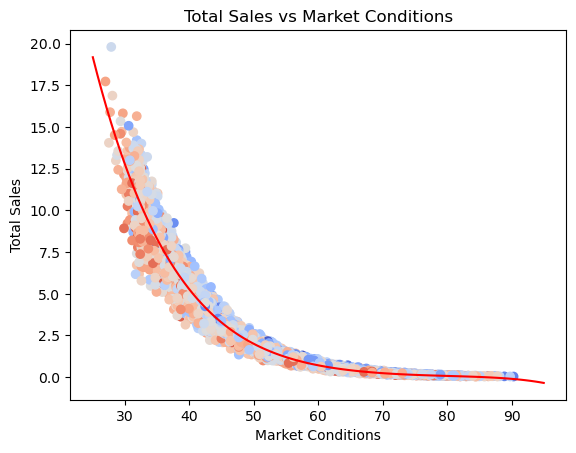

In [112]:
# Linear regression y=TS
# Note: make output_x**3 part of X
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Regression on weekends
data_to_reg = data.loc[data['bool_week_day'] == 0]

degree = 5
poly = PolynomialFeatures(degree)
output_X_poly = np.array(poly.fit_transform(data_to_reg['output_X'].values.reshape(-1, 1)))

X = np.concatenate((output_X_poly[:, 1:], data_to_reg['output_own_price'].values.reshape(-1, 1), data_to_reg['output_comp_price'].values.reshape(-1, 1)), axis=1)
y = data_to_reg['total_sales']

reg_weekends = LinearRegression().fit(X, y)

print('Intercept: ', reg_weekends.intercept_)
print('Coefficients: ', reg_weekends.coef_)
print('R^2: ', reg_weekends.score(X, y))

# Plot
data_to_plot = data.loc[data['bool_week_day'] == 0]

plt.scatter(data_to_plot['output_X'], data_to_plot['total_sales'], c=data_to_plot['output_own_price'], cmap='coolwarm')

plt.xlabel('Market Conditions')
plt.ylabel('Total Sales')
plt.title('Total Sales vs Market Conditions')

line = np.linspace(25, 95, 100)
plt.plot(line, reg_weekends.intercept_ + np.sum([reg_weekends.coef_[i]*line**(i+1) for i in range(degree)],axis=0) + reg_weekends.coef_[degree]*data_to_plot['output_own_price'].mean() + reg_weekends.coef_[degree+1]*data_to_plot['output_comp_price'].mean(), 'r')

In [181]:
# Works amazing!

cost = 6.07
price_comp = 6.68
def profit_function(p1, weekday, cond):
    p2 = price_comp
    c = cost
    if weekday:
        degree = 6
        ts = reg_weekdays.intercept_ + np.sum([reg_weekdays.coef_[i]*cond**(i+1) for i in range(degree)],axis=0) + reg_weekdays.coef_[degree]*p1 + reg_weekdays.coef_[degree+1]*p2
        mu = 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[1] + (results_mle.x[2] + results_mle.x[3]) * (p1 - p2))))

    else:
        degree = 5
        ts = reg_weekends.intercept_ + np.sum([reg_weekends.coef_[i]*cond**(i+1) for i in range(degree)],axis=0) + reg_weekends.coef_[degree]*p1 + reg_weekends.coef_[degree+1]*p2
        mu = 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[2] * (p1 - p2))))
    
    return - (p1 - c) * mu * ts

params_init = np.array([cost+0.001])
cons = ({'type': 'ineq', 'fun': lambda x: x[0] - cost})
result = opt.minimize(profit_function, params_init, args=(0, 44.06), constraints=cons)

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.1877544858998785
       x: [ 6.842e+00]
     nit: 5
     jac: [ 1.429e-03]
    nfev: 12
    njev: 5